In [0]:
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')
clear_output()

In [0]:
!pip install --upgrade tensorflow-gpu
clear_output()

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
imdb_df = pd.read_csv("/content/drive/My Drive/SentimentAnalysisClassifier/Dataset/IMDB Dataset.csv")
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
#Check for nans
imdb_df.isna().sum()

review       0
sentiment    0
dtype: int64

In [8]:
#Encodes sentiment of the reviews
imdb_df["target"] = imdb_df.sentiment.astype("category").cat.codes
imdb_df.head()


,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


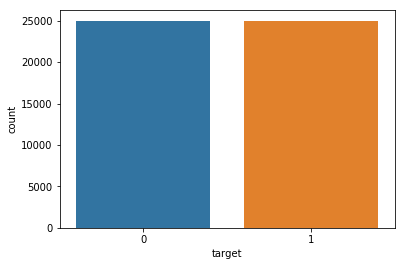

In [9]:
#Checks Dataset balance
sns.countplot(imdb_df["target"])
plt.show()

In [10]:
#Removes "<br />" from the text corpus, that have a high presence in the text corpus
imdb_df["review"] = imdb_df["review"].str.replace("<br />", "")
imdb_df.head()

,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [11]:
#Tokenize the string into sequences of int, one unique int for every word found in the text corpus
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(imdb_df["review"])
imdb_df.insert(1, "tokens", tokenizer.texts_to_sequences(imdb_df["review"]))
imdb_df.head()

,review,tokens,sentiment,target
0,One of the other reviewers has mentioned that ...,"[26, 4, 1, 78, 2099, 44, 1071, 11, 99, 146, 38...",positive,1
1,A wonderful little production. The filming tec...,"[3, 392, 119, 351, 1, 1384, 2976, 6, 51, 17947...",positive,1
2,I thought this was a wonderful way to spend ti...,"[9, 189, 10, 12, 3, 392, 94, 5, 1153, 54, 19, ...",positive,1
3,Basically there's a family where a little boy ...,"[689, 221, 3, 235, 116, 3, 119, 419, 3651, 125...",negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...","[71931, 33185, 111, 7, 1, 54, 4, 290, 6, 3, 21...",positive,1


med: 173.0
95.0%: 588.0


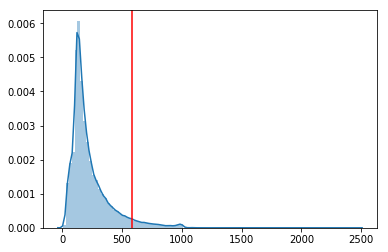

In [12]:
#Search for viable max lenght for seqeuences, avoiding space wasting by large number of zeros in every sequence
tokens_lenght = [len(seq) for seq in imdb_df["tokens"].values]
print("med: " + str(np.median(tokens_lenght)))

data_covered = 0.95
quantile = np.quantile(tokens_lenght, data_covered)
print(str(data_covered * 100) + "%: " + str(quantile))

sns.distplot(tokens_lenght, 100)
plt.axvline(quantile, color="red")
plt.show()

In [13]:
#Truncates only 5% of the data, and pad 95%
max_len = int(quantile)
imdb_df["tokens"] = tf.keras.preprocessing.sequence.pad_sequences(imdb_df["tokens"], max_len, padding="post", truncating="post").tolist()
imdb_df.head()

,review,tokens,sentiment,target
0,One of the other reviewers has mentioned that ...,"[26, 4, 1, 78, 2099, 44, 1071, 11, 99, 146, 38...",positive,1
1,A wonderful little production. The filming tec...,"[3, 392, 119, 351, 1, 1384, 2976, 6, 51, 17947...",positive,1
2,I thought this was a wonderful way to spend ti...,"[9, 189, 10, 12, 3, 392, 94, 5, 1153, 54, 19, ...",positive,1
3,Basically there's a family where a little boy ...,"[689, 221, 3, 235, 116, 3, 119, 419, 3651, 125...",negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...","[71931, 33185, 111, 7, 1, 54, 4, 290, 6, 3, 21...",positive,1


In [0]:
#splits data into Dataset ready for model training, evaluation and testing
imdb_ds = tf.data.Dataset.from_tensor_slices((imdb_df["tokens"], imdb_df["target"])).shuffle(2048)
imdb_test = imdb_ds.take(2500).batch(2500)
imdb_train = imdb_ds.skip(2500)
imdb_eval = imdb_train.take(2500).batch(2500)
imdb_train = imdb_train.skip(2500)

In [0]:
#Define our Model
class RNNClassifier(tf.keras.Model):
  """RNN Classifier"""

  def __init__(self, vocabulary_size, embedding_dim):
    super(RNNClassifier, self).__init__()

    self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dim, mask_zero=True)
    self.lstm_cell = tf.keras.layers.LSTM(embedding_dim, return_sequences=True)
    self.lstm_flat = tf.keras.layers.Flatten()
    self.dense_in = tf.keras.layers.Dense(embedding_dim, "relu")
    self.dense_out = tf.keras.layers.Dense(1, "sigmoid")

  def call(self, inputs):
    X = self.embedding(inputs)
    X = self.lstm_cell(X)
    X = self.lstm_flat(X)
    X = self.dense_in(X)
    X = self.dense_out(X)
    return X

In [0]:
#Parameters
vocabulary_size = len(tokenizer.word_index) + 1

#Hyperparameters
epochs = 20
lr = 0.01
embedding_dim = 64
batch_size = 512

In [0]:
#Model instantiation and compile
model = RNNClassifier(vocabulary_size, embedding_dim)
model.compile(tf.keras.optimizers.Adam(lr), tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

In [19]:
#Fitting
model.fit(imdb_train.batch(batch_size), epochs=epochs, validation_data=imdb_eval)

Epoch 1/20
88/88 [==============================] - 42s 477ms/step - loss: 0.6074 - binary_accuracy: 0.6734 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/20
88/88 [==============================] - 33s 373ms/step - loss: 0.1769 - binary_accuracy: 0.9314 - val_loss: 0.1925 - val_binary_accuracy: 0.9272
Epoch 3/20
88/88 [==============================] - 33s 373ms/step - loss: 0.0652 - binary_accuracy: 0.9775 - val_loss: 0.3177 - val_binary_accuracy: 0.9232
Epoch 4/20
88/88 [==============================] - 33s 372ms/step - loss: 0.0310 - binary_accuracy: 0.9904 - val_loss: 0.3373 - val_binary_accuracy: 0.9280
Epoch 5/20
88/88 [==============================] - 33s 374ms/step - loss: 0.0209 - binary_accuracy: 0.9939 - val_loss: 0.2622 - val_binary_accuracy: 0.9476
Epoch 6/20
88/88 [==============================] - 33s 373ms/step - loss: 0.0185 - binary_accuracy: 0.9946 - val_loss: 0.1859 - val_binary_accuracy: 0.9600
Epoch 7/20
88/88 [==============================] 

In [20]:
#Evaluate using test set
model.evaluate(imdb_test)

1/1 [==============================] - 1s 940ms/step - loss: 0.1697 - binary_accuracy: 0.9716


[0.16969336569309235, 0.9716]

In [0]:
#Save model weights to a new folder
dir_list = os.listdir("/content/drive/My Drive/SentimentAnalysisClassifier/Checkpoints/")
dir_list = list(map(int, dir_list))
next_dir = np.max(dir_list)
next_dir = "/content/drive/My Drive/SentimentAnalysisClassifier/Checkpoints/" + str(next_dir + 1)
os.mkdir(next_dir)

model.save_weights(next_dir + "/checkpoint")

In [0]:
#Preprocess raw text
def preprocess_text(str_list):
  seq_list = tokenizer.texts_to_sequences(str_list)
  seq_list = tf.keras.preprocessing.sequence.pad_sequences(seq_list, max_len, padding="post", truncating="post")
  return seq_list

In [25]:
#Make inference on custom test
test_review = input()
test_tokens = np.array(preprocess_text([test_review]))
result = model(test_tokens)
print(float(result))
if(result >= 0.5):
  print("positive")
else:
  print("negative")

i hate this
0.5422627329826355
positive
